In [4]:
import json #strips string from dictionary
import numpy as np
import pandas as pd
import timeit
import datetime
import matplotlib.pyplot as plt
from collections import Counter
import random
import ast
import os
random.seed(4612)

### Load CSV File

In [34]:
location = 'data/public_data.csv'
df = pd.read_csv(location, encoding = "ISO-8859-1")
df.head(4)

,date,category,income,description,amount
0,5/17/18,"['Food and Drink', 'Restaurants', 'Coffee Shop']",0,Starbucks,7.16
1,7/19/18,"['Shops', 'Supermarkets and Groceries']",0,Publix,83.38
2,4/22/18,"['Shops', 'Convenience Stores']",0,Eleven,16.10
3,7/6/18,"['Service', 'Insurance']",0,EarninActivehour PAY,148.00


In [35]:
len(df)

8996

## Feature Engineering

* <b>Take ['date'] and add day of week, day of month</b>
* <b> Take ['amount'] and add where if 0.00, 00.00 and if 000.00 </b>
* <b>Get Dummies on ['date']</b>

In [36]:
df['day_week_name'] = pd.to_datetime(df.date).dt.weekday_name
df['day_week_number'] = pd.to_datetime(df.date).dt.weekday
df['day_month'] = pd.to_datetime(df.date).dt.day
df = pd.concat([df,pd.get_dummies(df.day_week_name),pd.get_dummies(df.day_month,prefix='day')],axis=1)
#df = df.drop(labels=['day_week_name','day_month'], axis=1) #In future drop Sunday and #31
#0-> Monday; 5->Saturday; 6->Sunday
df['weekday'] = pd.Series(np.where(pd.to_datetime(df.date).dt.weekday >= 5, 1, 0))

df['amount_tens'] = pd.Series(np.where(df.amount % 10.00 == 0, 1, 0))
df['amount_hundreds'] = pd.Series(np.where(df.amount % 100.00 == 0, 1, 0))
df['amount_thousands'] = pd.Series(np.where(df.amount % 1000.00 == 0, 1, 0))

In [37]:
def split_categories(dataframe_column):
    new_list = []
    for i in dataframe_column:
        if ('[' in i) and (']' in i):
            new_list.append(ast.literal_eval(i))
        else:
            new_list.append([])
    categories = pd.DataFrame(np.array(new_list).tolist(), 
                              columns=['category_%s' % i for i in list(range(1,np.max([len(x) for x in new_list])+1))])
    return categories

In [38]:
split_categories(df.category)

,category_1,category_2,category_3
0,Food and Drink,Restaurants,Coffee Shop
1,Shops,Supermarkets and Groceries,None
2,Shops,Convenience Stores,None
3,Service,Insurance,None
4,Shops,Pharmacies,None
5,Bank Fees,Wire Transfer,None
6,Travel,Car Service,Ride Share
7,Food and Drink,Restaurants,None
8,Food and Drink,None,None
9,Service,Credit Counseling and Bankruptcy Services,None


In [39]:
df = pd.concat([df,split_categories(df.category)],axis=1)

In [40]:
df.category_1.nunique()

12

In [41]:
df.category_2.nunique()

110

In [42]:
df.category_3.nunique()

69

## Visuals

In [43]:
df_income = df[df.amount <0]

In [44]:
df_income.columns

Index(['date', 'category', 'income', 'description', 'amount', 'day_week_name',
       'day_week_number', 'day_month', 'Friday', 'Monday', 'Saturday',
       'Sunday', 'Thursday', 'Tuesday', 'Wednesday', 'day_1', 'day_2', 'day_3',
       'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10',
       'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17',
       'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24',
       'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31',
       'weekday', 'amount_tens', 'amount_hundreds', 'amount_thousands',
       'category_1', 'category_2', 'category_3'],
      dtype='object')

In [50]:
weekday_pivot = pd.pivot_table(df_income, values=['date'], index=['day_week_number','day_week_name'], columns=['income'],aggfunc='count')
weekday_pivot['income_prob']=round(weekday_pivot.date[1.0]/(weekday_pivot.date[0.0]+weekday_pivot.date[1.0]),3)
weekday_pivot

date      income_prob
income                           0    1            
day_week_number day_week_name                      
0               Monday         320   29       0.083
1               Tuesday        226   26       0.103
2               Wednesday      189   26       0.121
3               Thursday       204   57       0.218
4               Friday         245  103       0.296
5               Saturday        65    1       0.015
6               Sunday          39    3       0.071

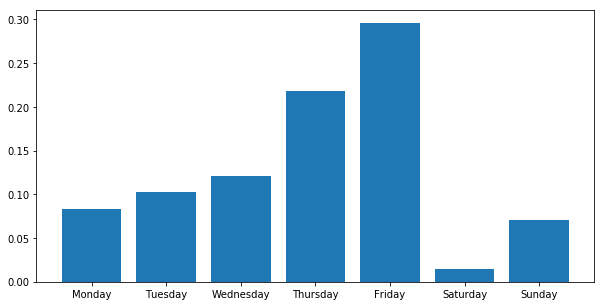

In [52]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar([i[1] for i in weekday_pivot.date.index],weekday_pivot.income_prob)
plt.show()

In [53]:
month_pivot = pd.pivot_table(df_income, values=['date'], index=['day_month'], columns=['income'],aggfunc='count')
month_pivot['income_prob']=round(month_pivot.date[1.0]/(month_pivot.date[0.0]+month_pivot.date[1.0]),3)

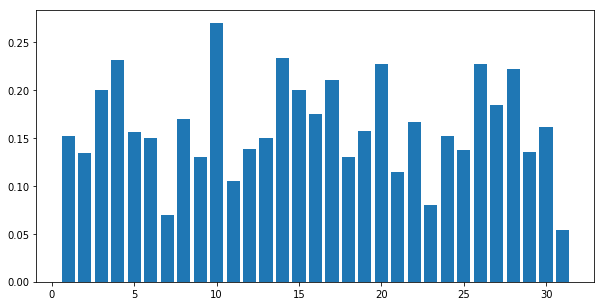

In [54]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(month_pivot.index,month_pivot.income_prob)
plt.show()

In [55]:
amount_tens_pivot = pd.pivot_table(df_income, values=['date'], index=['amount_tens'], columns=['income'],aggfunc='count')
amount_tens_pivot['income_prob']=round(amount_tens_pivot.date[1.0]/(amount_tens_pivot.date[0.0]+amount_tens_pivot.date[1.0]),3)
amount_tens_pivot

date      income_prob
income         0    1            
amount_tens                      
0            733  233       0.241
1            555   12       0.021

In [56]:
amount_hundreds_pivot = pd.pivot_table(df_income, values=['date'], index=['amount_hundreds'], columns=['income'],aggfunc='count')
amount_hundreds_pivot['income_prob']=round(amount_hundreds_pivot.date[1.0]/(amount_hundreds_pivot.date[0.0]+amount_hundreds_pivot.date[1.0]),3)
amount_hundreds_pivot

date      income_prob
income              0    1            
amount_hundreds                       
0                1069  239       0.183
1                 219    6       0.027

In [57]:
amount_thousands_pivot = pd.pivot_table(df_income, values=['date'], index=['amount_thousands'], columns=['income'],aggfunc='count')
amount_thousands_pivot['income_prob']=round(amount_thousands_pivot.date[1.0]/(amount_thousands_pivot.date[0.0]+amount_thousands_pivot.date[1.0]),3)
amount_thousands_pivot

date      income_prob
income               0    1            
amount_thousands                       
0                 1269  244       0.161
1                   19    1       0.050